In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Reading the data 
df = pd.read_csv('hw_aa.csv', sep=';')

In [3]:
df

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


100%|██████████| 1000/1000 [00:16<00:00, 61.40it/s]


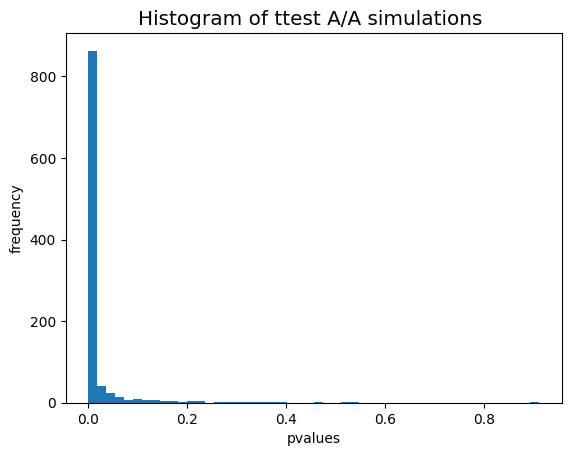

0.928

In [4]:
#Running the А/А-test and calculating the FPR to check if the groups are similar

n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # saving the p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Checking if the FPR is less that alpha
sum(np.array(res) <0.05) / simulations

The A/A test shows that FPR > alpha value (0.05), which means there are statistically significant differences between the groups. This suggests that the split system indeed doesn't work correctly.

Let's take a closer look at the data to find the cause of the failure of the splitting system. According to the data, users use different app versions, so I will group the users based on this criterion and calculate the total number of users in each group.

In [5]:
#Counting the convertion in the groups

df.groupby(['experimentVariant', 'version'], as_index=False)\
.agg({'purchase': 'mean', 'Unnamed: 0':'count'})

,experimentVariant,version,purchase,Unnamed: 0
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


We found that the lowest conversion is among users that use version v2.8.0 of the app, and the conversion in other groups is distributed evenly.
That being said, the number of users in each group is approximately the same, which means that the problem is not in the incorrect group sizes.

Probably the problem occurs with the usage of version v2.8.0. Let's try to exclude it and recalculate the FPR. 


100%|██████████| 1000/1000 [00:34<00:00, 29.10it/s]


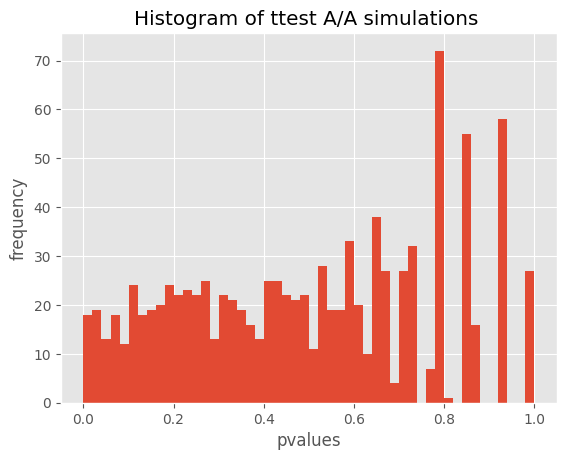

0.042

In [6]:
n = 100000
simulations = 1000
n_s = 1000
res = []

for i in tqdm(range(simulations)):
    version1 = df[(df.experimentVariant == 1)  & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    version2 = df[(df.experimentVariant == 0)  & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(version1, version2, equal_var = False)[1]) # saving the p-value

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Checking if the FPR is less that alpha
sum(np.array(res) <0.05) / simulations

Our assumption was confirmed - by excluding the group of users with the app version v2.8.0, we got an FPR less than the given alpha value. So, the problem lies in this version of the app.

For now, there is not enough data to identify what exactly causes the problem. To do this, it is necessary to study the data within this user group itself, possibly further dividing it based on other criteria (geographically, by the type of operating system used (iOS, Android), date of registration in the application, etc.)

In this case, we made a general cut and took only the first step in finding the problem.